In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
# xlrd is required for reading xls Excel files
import xlrd
import re
import sqlite3
import meteostat as mt
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do GAM regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

## Import PyGAM Library

Imports the Generalized Additive Models (GAM) library for flexible non-linear regression.

GAMs model the target variable as a sum of smooth functions of the features, allowing for complex non-linear relationships.


In [75]:
try:
    from pygam import LinearGAM, s, f, te
except ImportError:
    print("pygam is not installed. Please install it using 'pip install pygam' to use GAM regression features.")
    %pip install pygam
    from pygam import LinearGAM, s, f, te

## Configure File Paths and Solar Parameters

Sets up the directory paths for data and models used throughout the analysis:
- Determines the notebook's current directory
- Defines paths to training, testing, and processed data
- Configures solar panel parameters (19 panels, 8,360W total capacity)
- Sets location coordinates for Bettystown, Ireland


In [76]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


## Set Nighttime Threshold

Filters out nighttime data where Clear Sky GHI ≤ 50 W/m². 

Only daytime data with meaningful solar radiation is used for training the model.


In [77]:
hourly_nighlty_threshold = 50

# pyGAM (Generalized Additive Model) Regression Analysis Of Solar and Weather



In [78]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"
file_training_data = f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather"
file_testing_data = f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather"


__Load Test and Training Data_


In [79]:
df_daytime_train = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather")
df_daytime_test = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather")

# use list comprehension to get list of columns for level 1 and level 2 from weather data
# level 1 and levl 2 are based on condition codes from meteostat - it onehot encoding of weather conditions , with level 1 lowest level , and level 2 a summary level
level1_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level2_')]

## Display Dataset Structure

Shows the column names and data types of the training dataset to verify the data loaded correctly.


In [80]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_daytime_train.columns, "Data Types": df_daytime_train.dtypes}))


,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


## Histogram of various solar measures 

This shows a histogram of the various measures solar output. 

In [81]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="999"
# Define target column

#target_col = 'PV(W)'
#target_col = 'Clearsky_Index'
target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"pyGAM - Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
#feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
#feature_cols.append('Power_ClearSky_Pane_I(W)')
#feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting pyGAM Regressor with target: {target_col} and features: {feature_cols}")



Testing pyGAM Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


## Prepare Training and Testing Data

Creates the feature matrices (X) and target vectors (y) for both training and testing datasets.

Splits the data into independent variables (features) and dependent variable (target) for model training and evaluation.


In [82]:

print(f"\nTesting pyGAM Regressor with target: {target_col} and features: {feature_cols}")
# 1. Remove the problematic rare feature
if 'level2_severe_weather' in feature_cols:
    feature_cols.remove('level2_severe_weather')
    print("Removed 'level2_severe_weather' from features.")
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]
# print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# 3. Update the indices
# We still have 13 continuous features (0-12)
# But now we have 4 categorical features instead of 5 (indices 13-16)
continuous_indices = list(range(0, 13)) 
categorical_indices = list(range(13, 17)) # Ends at 17 (exclusive), so 13, 14, 15, 16

print(f"New feature count: {len(feature_cols)}")


Testing pyGAM Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']
Removed 'level2_severe_weather' from features.
X_train shape: (2192, 17)
y_train shape: (2192,)
X_test shape: (2194, 17)
y_test shape: (2194,)
New feature count: 17


## Import PyGAM Library

Imports the Generalized Additive Models (GAM) library for flexible non-linear regression.

GAMs model the target variable as a sum of smooth functions of the features, allowing for complex non-linear relationships.


In [83]:
# Create and train pyGAM model
# Using spline terms for continuous features and factor terms for categorical
from pygam import LinearGAM, s, f

# Build GAM with smooth terms for continuous features (0-12) and factor terms for categorical (13-16)
# s() creates smooth spline terms for continuous variables
# f() creates factor terms for categorical variables
gam_model = LinearGAM(
    s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + 
    s(9) + s(10) + s(11) + s(12) + f(13) + f(14) + f(15) + f(16),
    max_iter=500
)

# Train the model
print("Fitting GAM model...")
gam_model.fit(X_train, y_train)
print("Fitting GAM model... Done")

# Make predictions
print("Making predictions on test set...")
y_test_pred = gam_model.predict(X_test)
print("Making predictions on test set... Done")

# making predictions on training set
print("Making predictions on training set...")
y_train_pred = gam_model.predict(X_train)
print("Making predictions on training set... Done")

print(f"Target Column {target_col}")


Fitting GAM model...


Fitting GAM model... Done
Making predictions on test set...
Making predictions on test set... Done
Making predictions on training set...
Making predictions on training set... Done
Target Column PV(W)_error


__Gemini Suggestions__

. Improved Model Definition & Grid Search
This code replaces your current manual model definition. It correctly assigns factor terms f() to categorical variables and uses gridsearch to automatically find the best smoothing parameters (lam) to prevent overfitting.

Strategic Improvements (Why this works)
Switching s() to f():

Why: s() tries to draw a smooth curve through data points. level2_precipitation is either 0 or 1. Drawing a curve between 0 and 1 is meaningless. f() calculates a simple intercept shift (e.g., "If raining, subtract 500W"), which is exactly what you want for dummy variables.

Grid Search (gam.gridsearch):

Why: Your previous model likely overfitted (Train R2 > Test R2). Grid search finds the optimal lam (lambda) for each feature. If a feature is noisy, it increases lambda to smooth it out; if a feature is strong, it decreases lambda to fit it closely.

Interaction Terms (te):

Why: This is often the "silver bullet" for solar.

Scenario A: It's noon (High ClearSky potential). A drop in sunshine duration kills output massively.

Scenario B: It's 7 PM (Low ClearSky potential). A drop in sunshine duration barely matters.

Standard LinearGAM adds effects: Effect(ClearSky) + Effect(Sun).

Tensor te() allows multiplication effects: Effect(ClearSky * Sun).

3. Better Target Variable: Clear Sky Index
If the Grid Search doesn't give you >0.85 R2, change your target variable. Predicting raw Watts or Error is hard because the magnitude changes constantly (0W at night, 4000W at noon).


In [84]:
import numpy as np
from pygam import LinearGAM, s, f, te

# 1. Build the Term List dynamically
terms = s(continuous_indices[0]) 

for i in continuous_indices[1:]:
    terms += s(i)
    
for i in categorical_indices:
    terms += f(i)

# 2. Add Interaction: ClearSky (Index 9) x Sunshine Duration (Index 2)
# Note: Ensure these indices are still correct. 
# Based on your list, 2 is Sunshine and 9 is ClearSky, so this remains valid.
terms += te(9, 2) 

# 3. Train
print("Fitting GAM model (this may take a moment)...")
# We use a small grid search to tune the smoothing
gam_model = LinearGAM(terms, max_iter=100)
gam_model.gridsearch(X_train.values, y_train.values, lam=np.logspace(-3, 3, 5))

print("Model fitted successfully.")
gam_model.summary()

# 4. Predict
y_test_pred = gam_model.predict(X_test)
y_train_pred = gam_model.predict(X_train)

  0% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


Fitting GAM model (this may take a moment)...


 20% (1 of 5) |#####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 40% (2 of 5) |##########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 60% (3 of 5) |###############           | Elapsed Time: 0:00:01 ETA:   0:00:00
 80% (4 of 5) |####################      | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


Model fitted successfully.
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     87.6323
Link Function:                     IdentityLink Log Likelihood:                                -17085.8007
Number of Samples:                         2192 AIC:                                             34348.866
                                                AICc:                                           34356.4235
                                                GCV:                                            386825.789
                                                Scale:                                            599.2433
                                                Pseudo R-Squared:                                   0.7498
Feature Fu

 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



In [85]:
# Depending on target column, inverse transform if necessary
if target_col in ['PV(W)']:
    y_train_pvw_pred = y_train_pred
    y_train_pvw = y_train
    y_test_pvw_pred = y_test_pred
    y_test_pvw = y_test
elif target_col in ['PV(W)_error']:
    y_train_pvw_pred = y_train_pred + X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train + X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = y_test_pred + X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test + X_test['Total_Power_ClearSky_Output(W)']
if target_col in ['Clearsky_Index']:    
    y_train_pvw_pred = y_train_pred * X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train * X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = y_test_pred * X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test * X_test['Total_Power_ClearSky_Output(W)']
elif target_col in ['PV(W)_error_index']:
    y_train_pvw_pred = (y_train_pred * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = (y_train * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = (y_test_pred * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = (y_test * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']


__Metrics for Tests 

In [86]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
# # do GAM regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score


# do GAM regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    normalization_factor = np.max(y_true) - np.min(y_true)
    #normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    # calculate accuracy as 1 - (mae / mean of y_true)
    accuracy_score = 1 - (mae / np.mean(y_true))
    return rmse, mae, r2 , n_rmse, n_mae, accuracy_score
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy = calculate_metrics(y_test, y_test_pred)
train_rmse_pvw, train_mae_pvw, train_r2_pvw, train_n_rmse_pvw, train_n_mae_pvw, train_accuracy_pvw = calculate_metrics(y_train_pvw, y_train_pvw_pred)
test_rmse_pvw, test_mae_pvw, test_r2_pvw, test_n_rmse_pvw, test_n_mae_pvw, test_accuracy_pvw = calculate_metrics(y_test_pvw, y_test_pvw_pred)
# print the metrics , output into a markdown table , include percentages for n_rmse and n_mae and accuracy
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100
)
from IPython.display import display, Markdown
display(Markdown(f"### pyGAM Regressor Performance Metrics {target_col}\n" + mk_string))
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |""".format(
    train_rmse_pvw, test_rmse_pvw,
    train_mae_pvw, test_mae_pvw,
    train_r2_pvw, test_r2_pvw,
    train_n_rmse_pvw*100, test_n_rmse_pvw*100,
    train_n_mae_pvw*100, test_n_mae_pvw*100,
    train_accuracy_pvw*100, test_accuracy_pvw*100
)
from IPython.display import display, Markdown
display(Markdown(f"### pyGAM Regressor Performance Metrics PV(W)\n" + mk_string))

### pyGAM Regressor Performance Metrics PV(W)_error
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 587.14              | 681.78              |
| MAE          | 440.41              | 515.21              |
| R2           | 0.7498              | 0.6190              |
| N-RMSE (%)   | 9.5035              | 10.8404              |
| N-MAE (%)    | 7.1284              | 8.1920              |
| Accuracy (%) | 129.0079              | 136.5993              |

### pyGAM Regressor Performance Metrics PV(W)
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 587.14              | 681.78              |
| MAE          | 440.41              | 515.21              |
| R2           | 0.8295              | 0.7574              |
| N-RMSE (%)   | 10.4495              | 12.1603              |
| N-MAE (%)    | 7.8381              | 9.1893              |
| Accuracy (%) | 75.0735              | 72.9600              |

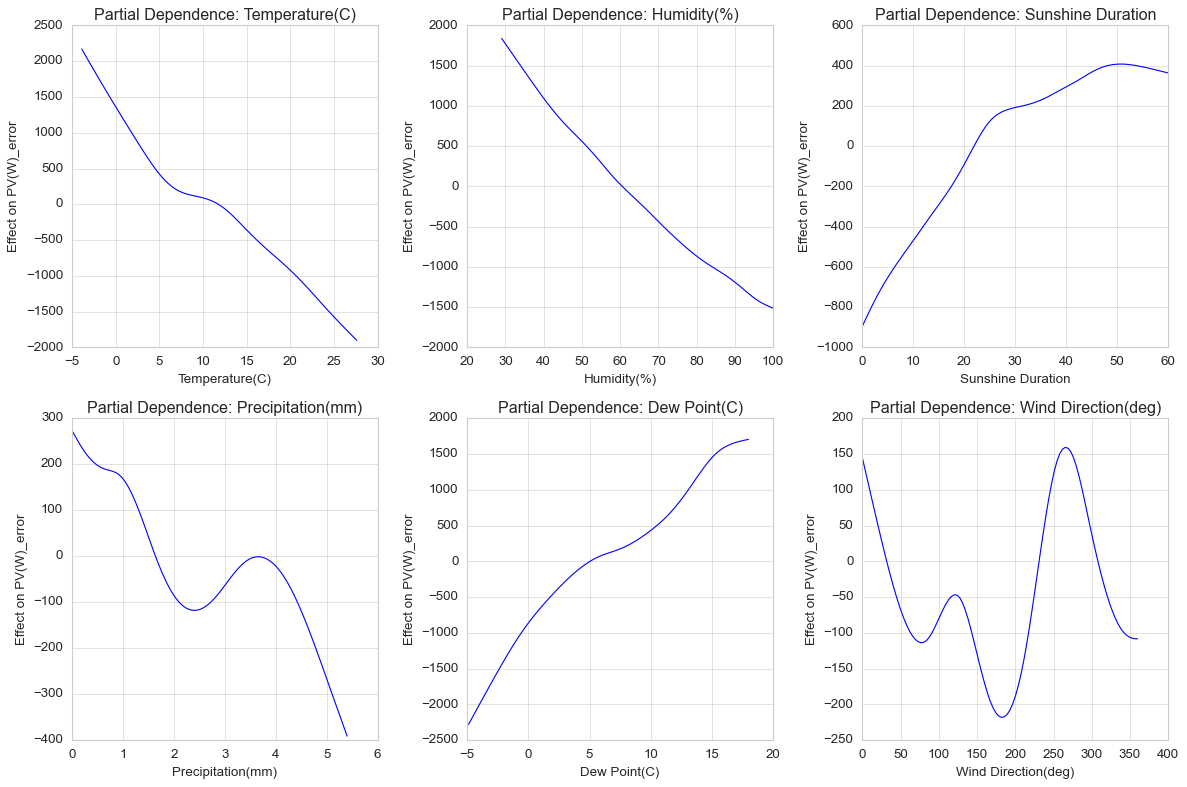


Top features by statistical significance (p-values):
{'n_samples': 2192, 'm_features': 17, 'edof_per_coef': array([3.23874765e-01, 3.22994891e-01, 4.03069149e-01, 3.21898996e-01,
       3.28993779e-01, 4.50400115e-01, 5.02185212e-01, 4.66098331e-01,
       5.35011183e-01, 5.48427615e-01, 5.72460856e-01, 5.65304626e-01,
       5.68623461e-01, 5.18464578e-01, 4.57934838e-01, 4.23596071e-01,
       2.64834832e-01, 5.49508360e-01, 2.51231820e-01, 4.33058702e-02,
       3.38564326e-01, 4.10757371e-01, 2.80430335e-01, 1.67947447e-01,
       3.06386785e-01, 3.82148409e-01, 3.68013374e-01, 4.44142342e-01,
       4.62557395e-01, 4.73623564e-01, 4.89731690e-01, 4.86924024e-01,
       4.97705553e-01, 4.86998411e-01, 4.79883740e-01, 4.98596620e-01,
       4.12839800e-01, 2.52850213e-01, 4.78806221e-02, 5.80949287e-02,
       7.60331167e-01, 4.33485687e-01, 4.47518886e-01, 4.83042127e-01,
       4.92419072e-01, 4.76602088e-01, 4.43432385e-01, 4.87780068e-01,
       4.47535585e-01, 4.18314320e-01, 

In [87]:
# GAM Feature Effects Visualization
# pyGAM allows us to visualize partial dependence for each feature
# This shows how each feature affects the prediction
from pygam import LinearGAM
import matplotlib.pyplot as plt

# Plot partial dependence for the first 6 features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(feature_cols):
        XX = gam_model.generate_X_grid(term=i)
        ax.plot(XX[:, i], gam_model.partial_dependence(term=i, X=XX))
        ax.set_title(f'Partial Dependence: {feature_cols[i]}')
        ax.set_xlabel(feature_cols[i])
        ax.set_ylabel('Effect on PV(W)_error')

plt.tight_layout()
plt.show()

print("\nTop features by statistical significance (p-values):")
print(gam_model.statistics_)


## Initialize GAM Model

Creates a Generalized Additive Model with spline terms for each feature.

Each feature is modeled with a smooth spline function, allowing the model to capture non-linear relationships while maintaining interpretability.


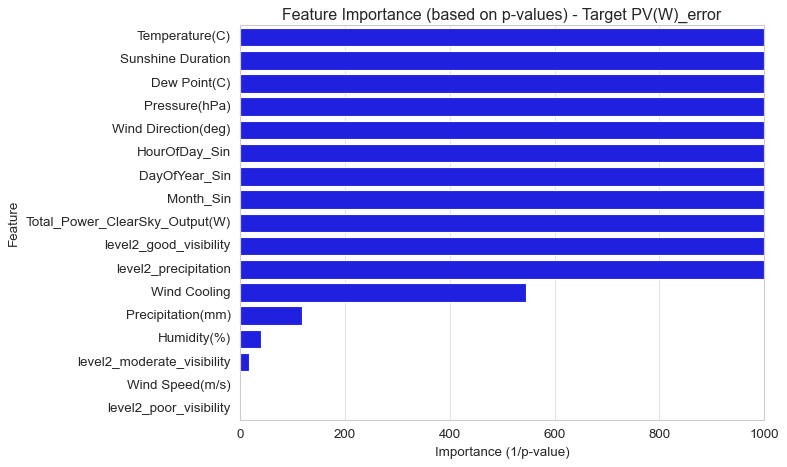


Top 10 Most Important Features:
                           Feature  Importance       P-Value
0                   Temperature(C)      1000.0  8.298278e-05
2                Sunshine Duration      1000.0  1.110223e-16
4                     Dew Point(C)      1000.0  1.972045e-11
7                    Pressure(hPa)      1000.0  8.897887e-09
5              Wind Direction(deg)      1000.0  9.099499e-09
12                   HourOfDay_Sin      1000.0  4.744828e-04
11                   DayOfYear_Sin      1000.0  1.110223e-16
10                       Month_Sin      1000.0  4.085621e-14
9   Total_Power_ClearSky_Output(W)      1000.0  1.110223e-16
13          level2_good_visibility      1000.0  4.595093e-07


In [88]:
# Create feature importance from GAM p-values
# Lower p-value = more statistically significant = more important
# We use 1/p-value as importance (but cap it to avoid infinity)
import pandas as pd

# Get p-values from GAM statistics
p_values = gam_model.statistics_['p_values']

# Convert to numpy array if it's a list
p_values_array = np.array(p_values)

# Match the length with feature_cols
# GAM may have more p-values than features (due to spline/factor terms)
# Use only the first len(feature_cols) p-values
n_features = len(feature_cols)
p_values_matched = p_values_array[:n_features]

# Create feature importance (inverse of p-value, capped)
# Add small value to avoid division by zero
importance = 1 / (p_values_matched + 1e-10)
# Cap very large values
importance = np.minimum(importance, 1000)

feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importance,
    'P-Value': p_values_matched
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.title(f'Feature Importance (based on p-values) - Target {target_col}')
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance (1/p-value)')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))


## Initialize GAM Model

Creates a Generalized Additive Model with spline terms for each feature.

Each feature is modeled with a smooth spline function, allowing the model to capture non-linear relationships while maintaining interpretability.


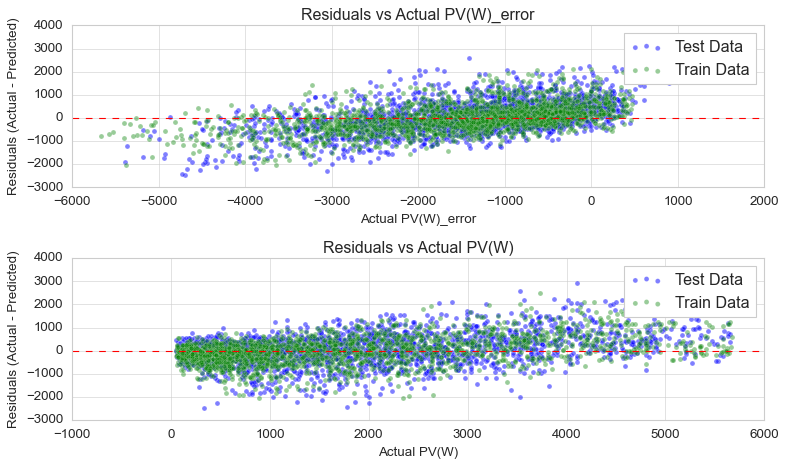

In [89]:
# plot residuals
#import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax = ax.flatten()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[0])
sns.scatterplot(x=y_train, y=y_train - y_train_pred, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title(f'Residuals vs Actual {target_col}')
ax[0].set_xlabel(f'Actual {target_col}')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test_pvw, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[1])
sns.scatterplot(x=y_train_pvw, y=y_train_pvw - y_train_pvw_pred, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title(f'Residuals vs Actual PV(W)')
ax[1].set_xlabel(f'Actual PV(W)')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.tight_layout()
plt.show()




## Initialize GAM Model

Creates a Generalized Additive Model with spline terms for each feature.

Each feature is modeled with a smooth spline function, allowing the model to capture non-linear relationships while maintaining interpretability.


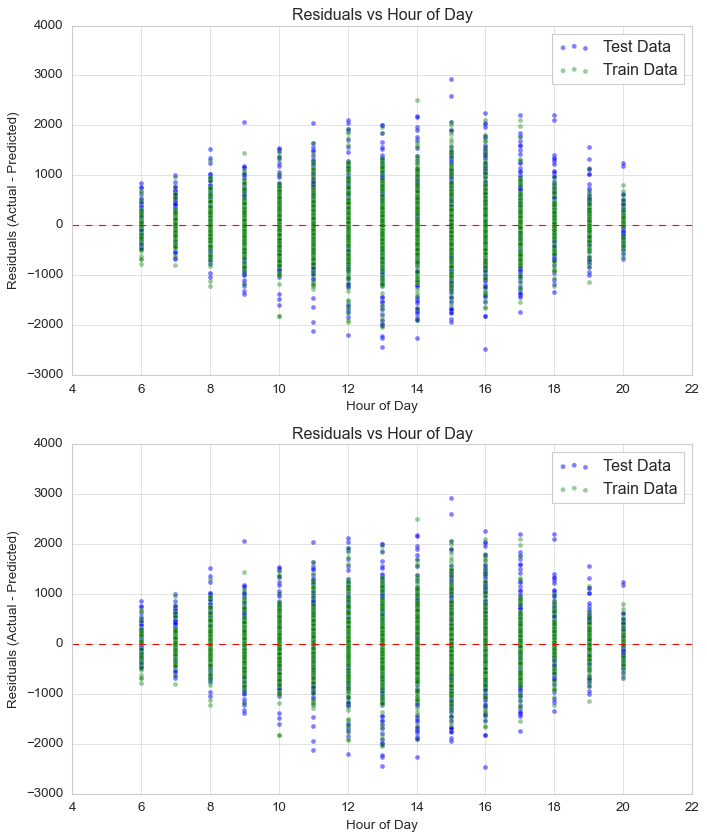

In [90]:
# plot risduals per hour of day
fig, ax = plt.subplots(2,1,figsize=(10,12))
ax = ax.flatten()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[0])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train - y_train_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title('Residuals vs Hour of Day')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[1])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train_pvw - y_train_pvw_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title('Residuals vs Hour of Day')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.show()

## Initialize GAM Model

Creates a Generalized Additive Model with spline terms for each feature.

Each feature is modeled with a smooth spline function, allowing the model to capture non-linear relationships while maintaining interpretability.


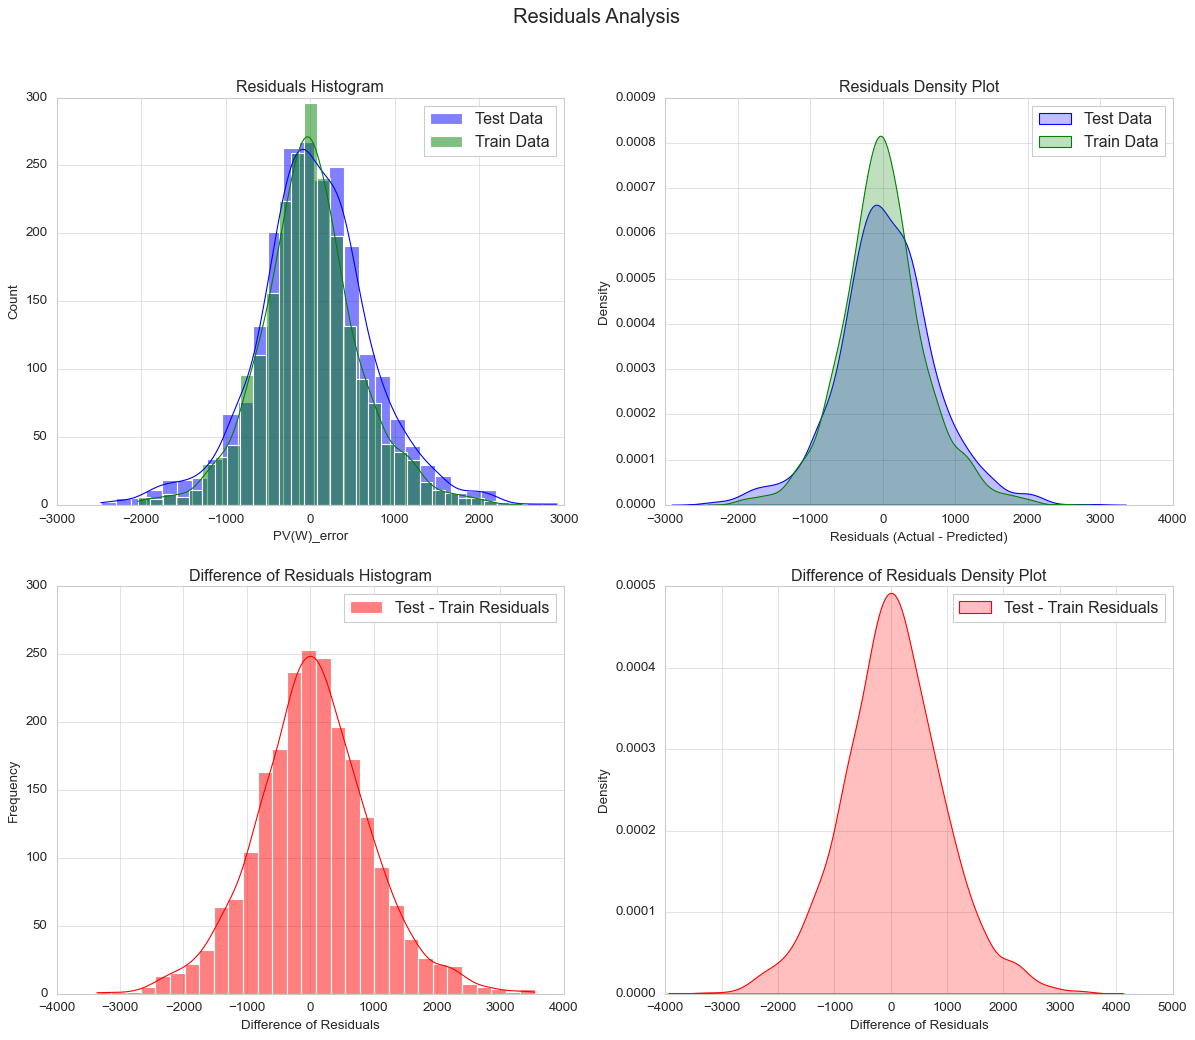

In [91]:
# Residual histogram
def plot_residuals_histogram():
    # Keep the main fig and ax definition
    fig, ax = plt.subplots(2, 2, figsize=(18, 14)) # Slightly taller to prevent title overlap
    ax = ax.flatten()
    fig.suptitle('Residuals Analysis', fontsize=18)
    
    # Subplot 1: Histograms
    sns.histplot(y_test - y_test_pred, color='blue', label='Test Data', kde=True, bins=30, ax=ax[0])
    sns.histplot(y_train - y_train_pred, color='green', label='Train Data', kde=True, bins=30, ax=ax[0])
    ax[0].set_title('Residuals Histogram')
    ax[0].legend() # Added legend here so you can see which is which

    # Subplot 2: Density (Removed the extra plt.figure call)
    sns.kdeplot(y_test - y_test_pred, color='blue', label='Test Data', fill=True, ax=ax[1])
    sns.kdeplot(y_train - y_train_pred, color='green', label='Train Data', fill=True, ax=ax[1])
    ax[1].set_title('Residuals Density Plot')
    ax[1].set_xlabel('Residuals (Actual - Predicted)')
    ax[1].set_ylabel('Density')
    ax[1].legend()
    # plot difference of residuals between train and test as histogram
    sns.histplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', kde=True, stat="count", bins=30, ax=ax[2])
    ax[2].set_title('Difference of Residuals Histogram')
    ax[2].set_xlabel('Difference of Residuals')
    ax[2].set_ylabel('Frequency')
    ax[2].legend()

    # plot difference of residuals
    sns.kdeplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', fill=True, ax=ax[3])
    ax[3].set_title('Difference of Residuals Density Plot')
    ax[3].set_xlabel('Difference of Residuals')
    ax[3].set_ylabel('Density')
    ax[3].legend()
    plt.show()


plot_residuals_histogram()

## QQ Plot of Residuals

Creates a Quantile-Quantile plot to assess if residuals follow a normal distribution.

Points should lie close to the diagonal line if residuals are normally distributed, indicating the residuals meet the assumption of normality.


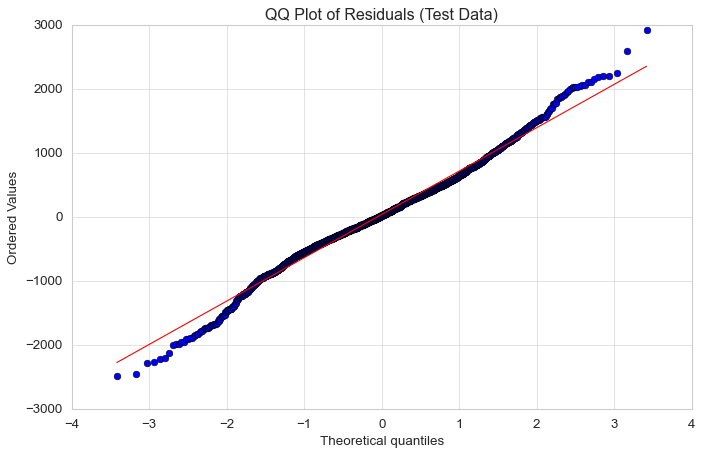

In [92]:
# Add QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10,6))
stats.probplot(y_test - y_test_pred, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (Test Data)')
plt.show()


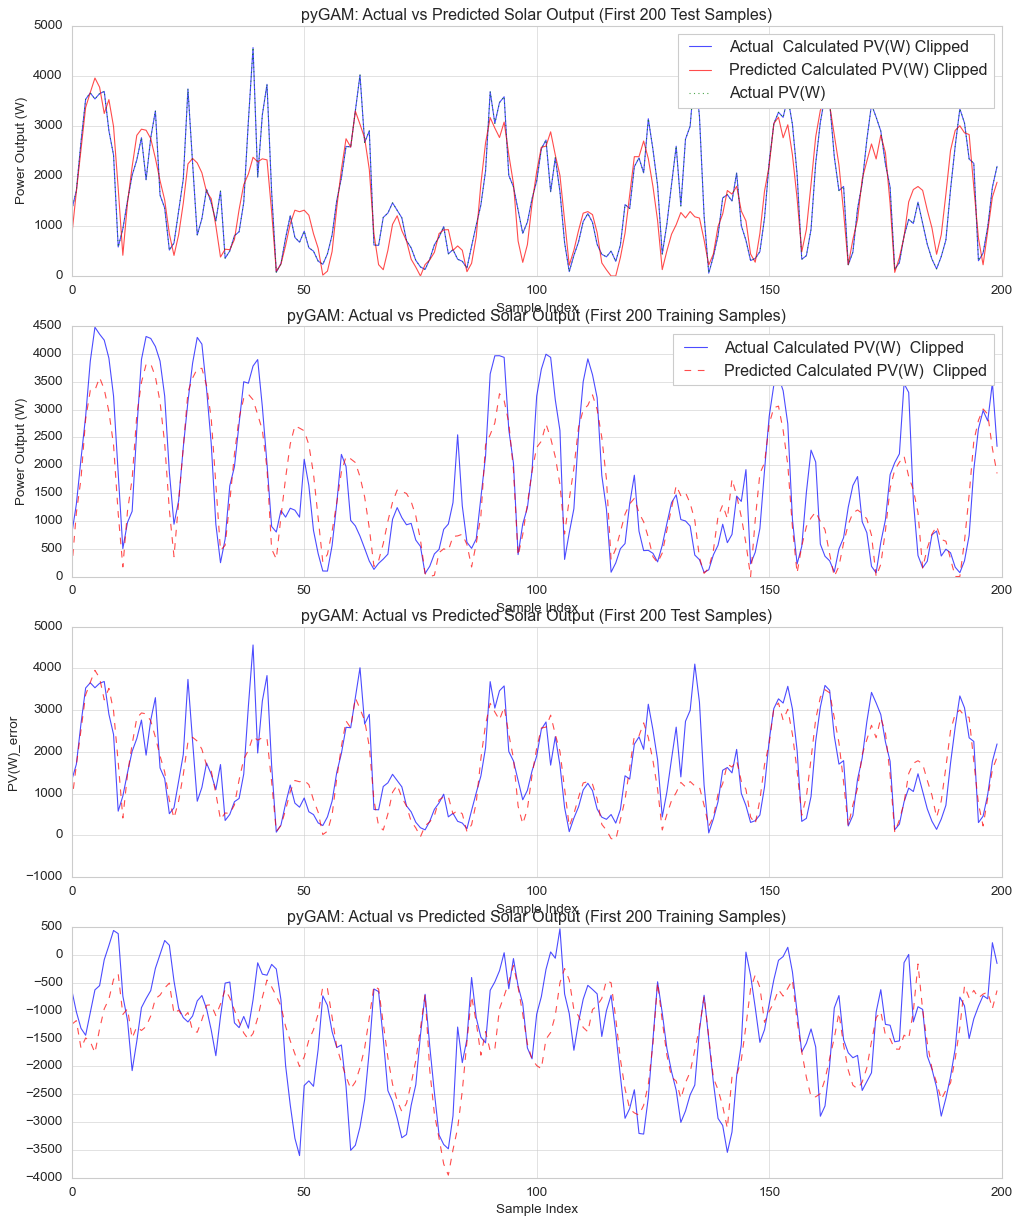

In [93]:
# Plot actual vs predicted for first 200 samples
fig, ax = plt.subplots(4,1,figsize=(15, 18))
ax = ax.flatten()
if target_col == 'PV(W)':
    ax[0].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    # add a gap between test and train plots
    ax[1].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
if target_col == 'Clearsky_Index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()

    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel(target_col)
    ax[3].legend()
if target_col == 'PV(W)_error' :
    ax[0].plot((y_test[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual  Calculated PV(W) Clipped' , color='blue', alpha=0.7)
    ax[0].plot((y_test_pred[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W) Clipped', color='red', alpha=0.7)
    ax[0].plot(df_daytime_test['PV(W)'][:200], label='Actual PV(W)', color='green', linestyle=':', alpha=0.7)
    ax[0].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot((y_train[:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual Calculated PV(W)  Clipped', color='blue', alpha=0.7)
    ax[1].plot((y_train_pred[:200]+ df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W)  Clipped', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test_pvw[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pvw_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    #ax[2].legend()
    #ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    #ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    #ax[2].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Test Samples)')
    #ax[2].set_xlabel('Sample Index')
    #ax[2].set_ylabel(target_col)
    #ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel        
if target_col == 'PV(W)_error_index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('pyGAM: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel

plt.show()

## Visualize Predictions Over Time

Creates a time series plot showing actual vs predicted values over a 5-day period.

This helps visualize how well the model tracks temporal patterns in solar power generation.


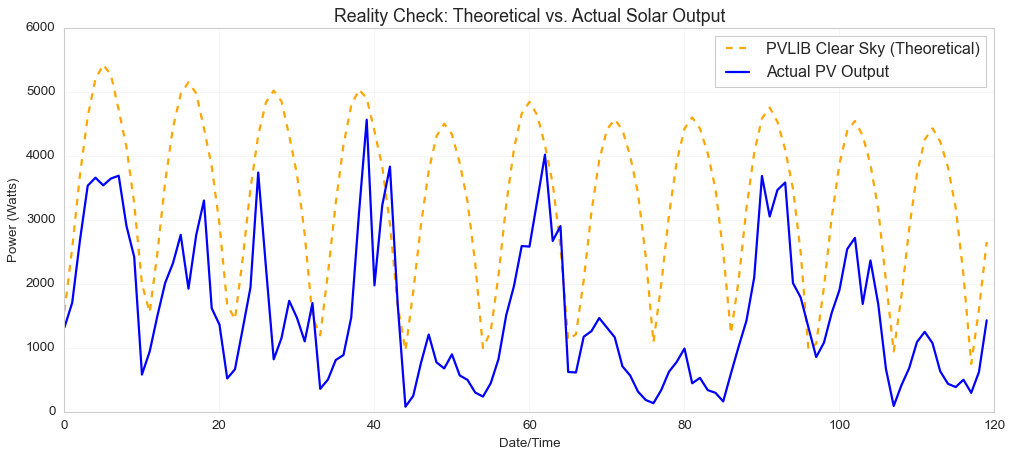

In [94]:
import matplotlib.pyplot as plt

# 1. Select a slice of data (e.g., 5 days from the test set)
# We pick a start point and take 120 hours (5 days * 24 hours)
start_idx = 0  # Change this to look at different weeks!
end_idx   = start_idx + 120

subset = df_daytime_test.iloc[start_idx:end_idx]

# 2. Setup the Plot
plt.figure(figsize=(15, 6))

# 3. Plot the Curves
# The "Theoretical Maximum" (PVLIB)
plt.plot(subset.index, subset['Total_Power_ClearSky_Output(W)'], 
         label='PVLIB Clear Sky (Theoretical)', color='orange', linestyle='--', linewidth=2)

# The "Actual Reality"
plt.plot(subset.index, subset['PV(W)'], 
         label='Actual PV Output', color='blue', linewidth=2)

# Optional: Plot your Hybrid Prediction if you have it!
# plt.plot(subset.index, y_pred_hybrid[start_idx:end_idx], label='Hybrid Prediction', color='green')

# 4. Make it readable
plt.title('Reality Check: Theoretical vs. Actual Solar Output', fontsize=16)
plt.ylabel('Power (Watts)', fontsize=12)
plt.xlabel('Date/Time', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## Initialize GAM Model

Creates a Generalized Additive Model with spline terms for each feature.

Each feature is modeled with a smooth spline function, allowing the model to capture non-linear relationships while maintaining interpretability.


In [95]:
# --- 1. Reconstruct Actual Values (same as before) ---
# We need the real PV output to compare against ClearSky
train_actual_pv = (y_train + df_daytime_train['Total_Power_ClearSky_Output(W)'])
train_clearsky  = df_daytime_train['Total_Power_ClearSky_Output(W)']

# --- 2. Calculate the "System Efficiency Factor" ---
# We only look at the top 10% of high-power times to ignore cloudy days.
# This gives us the ratio when the sun IS shining.
high_power_mask = train_actual_pv > train_actual_pv.quantile(0.90)

# Calculate ratio (Actual / ClearSky) for these bright moments
performance_factor = (train_actual_pv[high_power_mask] / train_clearsky[high_power_mask]).median()

print(f"☀️ Calculated System Performance Factor: {performance_factor:.4f}")
print("This means your system is performing at about {:.1f}% of the theoretical maximum.".format(performance_factor*100))

# --- 3. Create the NEW Corrected Target ---
# New Baseline = ClearSky * Factor
# New Target   = Actual - New Baseline
new_base_train = train_clearsky * performance_factor
new_target_train = train_actual_pv - new_base_train

new_base_test = df_daytime_test['Total_Power_ClearSky_Output(W)'] * performance_factor
y_test_actual_reconstructed = (y_test + df_daytime_test['Total_Power_ClearSky_Output(W)']) # Actual Test PV

# --- 4. Train a New pyGAM on this Corrected Target ---
print("\nTraining new Calibrated Residual Model...")
gam_calibrated = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16), max_iter=500)
gam_calibrated.fit(X_train, new_target_train)

# --- 5. Predict and Evaluate ---
# Predict the error
y_pred_new_error = gam_calibrated.predict(X_test)

# Add error back to the NEW baseline
y_pred_final_calibrated = (y_pred_new_error + new_base_test).clip(lower=0)

# Calculate Metrics
from sklearn.metrics import mean_squared_error, r2_score
rmse_calib = np.sqrt(mean_squared_error(y_test_actual_reconstructed, y_pred_final_calibrated))
n_rmse_calib = rmse_calib / y_test_actual_reconstructed.mean()
r2_calib = r2_score(y_test_actual_reconstructed, y_pred_final_calibrated)

print(f"\n--- Results for Calibrated Model (Factor: {performance_factor:.2f}) ---")
print(f"R² Score:  {r2_calib:.4f}")
print(f"RMSE:      {rmse_calib:.2f} W")
print(f"nRMSE:     {n_rmse_calib:.4f} ({n_rmse_calib*100:.2f}%)")

☀️ Calculated System Performance Factor: 0.8339
This means your system is performing at about 83.4% of the theoretical maximum.

Training new Calibrated Residual Model...

--- Results for Calibrated Model (Factor: 0.83) ---
R² Score:  0.7276
RMSE:      722.35 W
nRMSE:     0.3791 (37.91%)


Write results to CSV file

In [96]:
with open(f'results/pygam_regressor_hourly_test_metrics.csv', 'a') as f:
    # if this is first line write header
    if os.stat(f'results/pygam_regressor_hourly_test_metrics.csv').st_size == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train Accuracy','Train N-RMSE %', 'Train N-MAE %', 
                  'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',
                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) Accuracy','Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %',
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\n')
    line=[]
    line.append("pyGAM Regressor Hourly")
    line.append(str(test_no))
    line.append(str(target_col))
    line.append(str(test_name))
    line.append(f"{test_rmse:.2f}")
    line.append(f"{test_mae:.2f}")
    line.append(f"{test_r2:.4f}")
    line.append(f"{test_n_rmse:.4f}")
    line.append(f"{test_n_mae:.4f}")
    line.append(f"{test_n_rmse*100:.4f}")
    line.append(f"{test_n_mae*100:.4f}")
    line.append(f"{test_accuracy:.4f}")
    line.append(f"{train_rmse:.2f}")
    line.append(f"{train_mae:.2f}")
    line.append(f"{train_r2:.4f}")
    line.append(f"{train_n_rmse:.4f}")
    line.append(f"{train_n_mae:.4f}")
    line.append(f"{train_n_rmse*100:.4f}")
    line.append(f"{train_n_mae*100:.4f}")
    line.append(f"{train_accuracy:.4f}")
    line.append(f"{test_rmse_pvw:.2f}")
    line.append(f"{test_mae_pvw:.2f}")
    line.append(f"{test_r2_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw:.4f}")
    line.append(f"{test_n_mae_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw*100:.4f}")
    line.append(f"{test_n_mae_pvw*100:.4f}")
    line.append(f"{test_accuracy_pvw:.4f}")
    line.append(f"{train_rmse_pvw:.2f}")
    line.append(f"{train_mae_pvw:.2f}")
    line.append(f"{train_r2_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw:.4f}")
    line.append(f"{train_n_mae_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw*100:.4f}")
    line.append(f"{train_n_mae_pvw*100:.4f}")
    line.append(f"{train_accuracy_pvw:.4f}")
    line.append(f"{notes if 'notes' in locals() else ''}")
    line.append(f"feature_cols: {':'.join(feature_cols)}")
    f.write(','.join(line) + '\n')
